In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

In [2]:
# --- Configuration ---
DATASET_PATH = Path("data_split") # Path to the folder with pre-split CSVs
INTERMEDIATE_THRESHOLDS = np.round(np.arange(0.1, 10.0, 0.1), 1) # 99 points
TARGET_COL = 'overall_accuracy'
PARAMS_REDUCTION_COL = 'params_reduction_pct'

In [3]:
# --- 1. Load Validation Dataset ---
print("Loading validation dataset...")
try:
    validation_df_raw = pd.read_csv(DATASET_PATH / "validation_dataset.csv")
except FileNotFoundError as e:
    print(f"Error: Dataset file not found. Make sure '{e.filename}' exists.")
    print(f"Please run the `prepare_datasets.py` script first to generate '{DATASET_PATH / 'validation_dataset.csv'}'.")
    exit()

# Round the threshold column to fix precision issues (good practice)
print("Rounding threshold column to 1 decimal place...")
validation_df = validation_df_raw.copy()
validation_df['threshold'] = validation_df['threshold'].round(1)

print(f"Validation data shape (after rounding): {validation_df.shape}")

Loading validation dataset...
Rounding threshold column to 1 decimal place...
Validation data shape (after rounding): (202, 18)


In [4]:
# --- 2. Implement Baseline Model Prediction ---
print("\nApplying baseline model logic to validation data...")
baseline_predictions_all = []
actual_accuracies_all = []
model_ids_for_plot = [] # To select one for plotting
acc0_for_plot = {}
acc10_for_plot = {}


for model_id, group in validation_df.groupby('model_id'):
    group = group.sort_values(by='threshold').reset_index(drop=True)

    acc_at_0_series = group[group['threshold'] == 0.0][TARGET_COL]
    acc_at_10_series = group[group['threshold'] == 10.0][TARGET_COL] # For plotting actual end

    if acc_at_0_series.empty:
        print(f"Warning: Skipping model_id {model_id} due to missing acc_0 data.")
        continue
    
    acc_0_val = acc_at_0_series.iloc[0]
    
    # Store for plotting
    if model_id not in acc0_for_plot: # Store only once
        model_ids_for_plot.append(model_id)
        acc0_for_plot[model_id] = acc_0_val
        if not acc_at_10_series.empty:
            acc10_for_plot[model_id] = acc_at_10_series.iloc[0]
        else:
            acc10_for_plot[model_id] = np.nan


    intermediate_data = group[group['threshold'].isin(INTERMEDIATE_THRESHOLDS)].copy()
    if len(intermediate_data) != len(INTERMEDIATE_THRESHOLDS):
        # This might happen if a model in validation_df is incomplete even after prepare_datasets.py
        # For baseline, we can try to predict for what's available or skip. Let's predict for available.
        print(f"Warning: model_id {model_id} has {len(intermediate_data)} intermediate points, expected {len(INTERMEDIATE_THRESHOLDS)}. Predicting for available points.")
        if intermediate_data.empty:
            continue

    # Ensure order is correct for sequence
    intermediate_data = intermediate_data.sort_values(by='threshold')

    # Get parameter reduction percentages for intermediate thresholds
    params_reduction_pct_intermediate = intermediate_data[PARAMS_REDUCTION_COL].values

    # Apply baseline logic
    predicted_accuracies_intermediate = acc_0_val * (1 - (params_reduction_pct_intermediate / 100.0))
    
    # Clip predictions to be within [0, 1]
    predicted_accuracies_intermediate = np.clip(predicted_accuracies_intermediate, 0, 1)
    
    # Get actual accuracies for intermediate thresholds
    actual_accuracies_intermediate = intermediate_data[TARGET_COL].values

    # Store predictions and actuals for these specific intermediate points
    # This handles cases where a model might not have all 99 points, by only comparing available ones.
    baseline_predictions_all.extend(predicted_accuracies_intermediate)
    actual_accuracies_all.extend(actual_accuracies_intermediate)

if not baseline_predictions_all:
    print("Error: No baseline predictions could be made. Check validation data and logic.")
    exit()


Applying baseline model logic to validation data...


In [5]:
# --- 3. Calculate MAE on the Validation Set ---
baseline_mae = mean_absolute_error(actual_accuracies_all, baseline_predictions_all)
print(f"\nBaseline Model MAE on Validation Set: {baseline_mae:.4f}")


Baseline Model MAE on Validation Set: 0.2805



Plotting results for model_id: 5


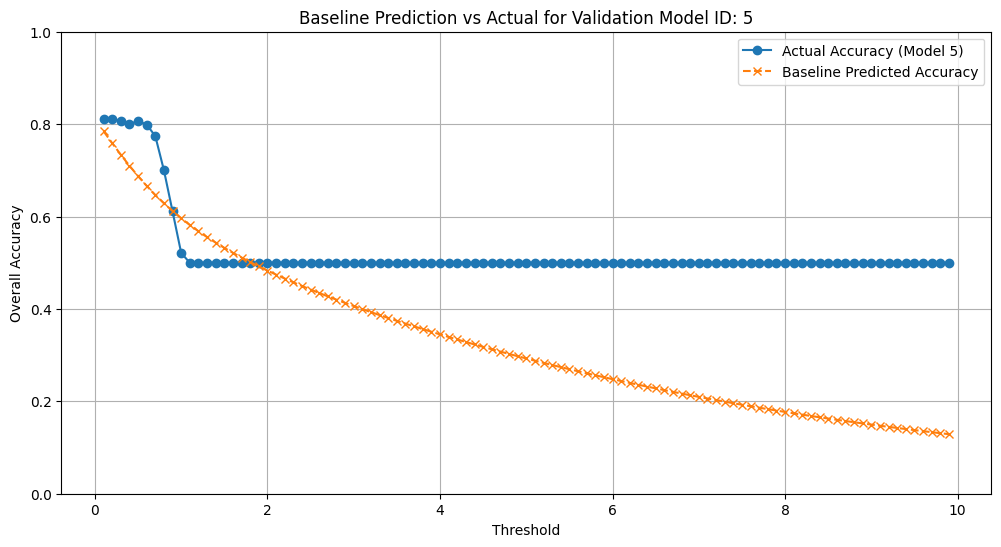

In [6]:
# --- 4. Plot one example chart ---
if model_ids_for_plot:
    plot_model_id = model_ids_for_plot[0] # Plot the first model processed
    print(f"\nPlotting results for model_id: {plot_model_id}")

    model_group_for_plot = validation_df[validation_df['model_id'] == plot_model_id].sort_values(by='threshold')
    
    # Get actual intermediate data for this model
    actual_intermediate_df = model_group_for_plot[model_group_for_plot['threshold'].isin(INTERMEDIATE_THRESHOLDS)]
    actual_thresholds_plot = actual_intermediate_df['threshold'].values
    actual_accuracies_plot = actual_intermediate_df[TARGET_COL].values

    # Regenerate baseline predictions specifically for this model for plotting
    # (to ensure alignment if some points were missing for MAE calculation)
    params_reduction_plot = actual_intermediate_df[PARAMS_REDUCTION_COL].values
    current_acc0 = acc0_for_plot[plot_model_id]
    baseline_predictions_plot = current_acc0 * (1 - (params_reduction_plot / 100.0))
    baseline_predictions_plot = np.clip(baseline_predictions_plot, 0, 1)

    plt.figure(figsize=(12, 6))
    plt.plot(actual_thresholds_plot, actual_accuracies_plot, label=f'Actual Accuracy (Model {plot_model_id})', marker='o', linestyle='-')
    plt.plot(actual_thresholds_plot, baseline_predictions_plot, label=f'Baseline Predicted Accuracy', marker='x', linestyle='--')

    plt.title(f"Baseline Prediction vs Actual for Validation Model ID: {plot_model_id}")
    plt.xlabel("Threshold")
    plt.ylabel("Overall Accuracy")
    plt.legend()
    plt.grid(True)
    
    # Dynamic Y-axis limits
    all_plot_values = np.concatenate([actual_accuracies_plot, baseline_predictions_plot, [current_acc0]])
    if plot_model_id in acc10_for_plot and not np.isnan(acc10_for_plot[plot_model_id]):
        all_plot_values = np.append(all_plot_values, acc10_for_plot[plot_model_id])
        
    min_val_plot = np.nanmin(all_plot_values)
    max_val_plot = np.nanmax(all_plot_values)
    plt.ylim(min(0, min_val_plot - 0.05) , max(1, max_val_plot + 0.05))
    
    plt.show()
else:
    print("No models were suitable for plotting.")